In [48]:
import numpy
import os

import scipy.sparse as sparse
import scipy.sparse.linalg

import matplotlib.pyplot as plt
#import matplotlib.animation as animation
from matplotlib import animation, rc
from IPython.display import HTML

In [197]:
Nx = 200
Nt = 2*Nx

# domaine spatial et maillage
X_min = 0
X_max = 1
h = 1/Nx
X = numpy.zeros(Nx)
for i in range(0,Nx):
    X[i] = X_min + i*h*(X_max-X_min)

# domaine temporel
Temps_final = 1
dt = Temps_final/Nt
        

In [198]:
A = 0.5
eps = 0.5

# fonction initiale
def u_ini(x):
    return 1+ eps*numpy.sin(2*numpy.pi*x)

# champ vitesse
def a_func(x):
    return 1+A*numpy.cos(2*numpy.pi*x)

# solution approchee 
u_tx = numpy.zeros((Nt+1, Nx))

# tableau des masses
mass = numpy.zeros((Nt+1))

In [199]:
# sol exacte  --  lorsqu'elle est connue !
def u_ex(t,x):
    return 0

In [200]:
def get_times_array_for(array):
    Nta = len(array)-1
    dta = Temps_final/Nta
    times = numpy.zeros(Nta+1)
    for n in range(0,Nta+1):
        times[n] = n*dta
    return times

In [1]:
def plot_sol(nt, plot_u_ex=False, Y_min=0, Y_max=2, save_fn=None):
    if False: #plot_u_ex:
        plt.plot(X, u_ex(nt*dt,X), '-', color='r')
        
    plt.xlim(X_min, X_max)
    plt.ylim(Y_min, Y_max)
    plt.xlabel('x')
    plt.plot(X, u_tx[nt,:], '-', color='k')
    if save_fn is not None:
        plt.savefig(save_fn)
    plt.show()

def plot_x_curves(
    array1=None, label1=None, 
    array2=None, label2=None, 
    array3=None, label3=None,
    name="some values along x", save_fn=None, logscale=False
):
    """
    to do
    """
    
    
def plot_t_curves(
    array1=None, label1=None, 
    array2=None, label2=None, 
    array3=None, label3=None,
    name="some values along time", save_fn=None, logscale=False
):
    plt.xlabel('t')
    plt.ylabel(name)
    if logscale:
        plt.yscale("log")
    assert array1 is not None
    times = get_times_array_for(array1)
    plt.plot(times, array1, '-', label=label1)
    if array2 is not None:
        times = get_times_array_for(array2)
        plt.plot(times, array2, '-', label=label2)
    if array3 is not None:
        times = get_times_array_for(array3)        
        plt.plot(times, array3, '-', label=label3)
    if save_fn is not None:
        plt.savefig(save_fn)
    if label1 is not None:
        plt.legend()
    plt.show()
    

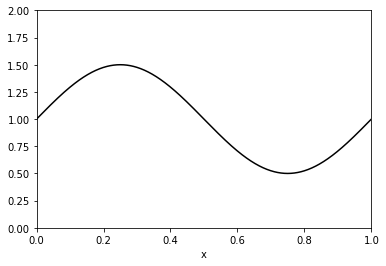

mass =  1.0


In [202]:
## initialisation de la solution avec u_ini
u_tx[0,:] = u_ini(X)
plot_sol(0, plot_u_ex=True, save_fn="u_ini.png")

mass[0] = h*numpy.sum(u_tx[0,:])
print("mass = ",mass[0])

## vitesse
a = numpy.zeros((Nx,))
a[:] = a_func(X)


In [203]:
# choix du type de schema: implicite ou explicite
implicit_scheme = False


In [204]:
# assemblage d'une matrice creuse M (pour un schema implicite)
if implicit_scheme:
    row = list()
    col = list()
    data = list()
    for i in range(0,Nx):

        # M_i,i = qque chose (exemple)
        row.append((i))
        col.append((i))
        data.append( 1+0.5*dt/h )  
    
        # M_i,i-1 = autre chose (exemple)
        row.append((i))
        col.append((numpy.mod(i-1,Nx)))  # modulo pour conditions periodiques
        data.append( -0.5*dt/h )

    row = numpy.array(row)
    col = numpy.array(col)
    data = numpy.array(data)      
    M = (sparse.coo_matrix((data, (row, col)), shape=(Nx, Nx))).tocsr()
else:
    M = None

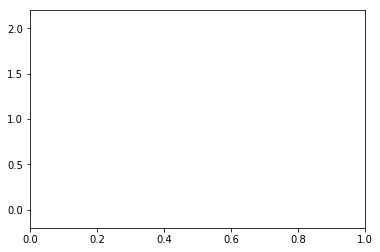

In [205]:
# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots()

# on garde les bornes pour afficher les solutions
u_min = 0 #min(u_tx[0,:])
u_max = 2 # max(u_tx[0,:])
Y_min = u_min - 0.1*(u_max-u_min)
Y_max = u_max + 0.1*(u_max-u_min)    

ax.set_xlim(( 0, 1))
ax.set_ylim((Y_min, Y_max))

line, = ax.plot([], [], lw=2)
line2, = ax.plot([], [], lw=2, color='r')

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    line2.set_data([], [])
    return (line,line2)


In [2]:
## schema numerique  

for nt in range(0,Nt):               
    if implicit_scheme:
        u_tx[nt+1,:] = sparse.linalg.spsolve(M, u_tx[nt,:])

    else:
        for i in range(0,Nx):        
            u_tx[nt+1,i] = 0.9*u_tx[nt,i]   # todo
            
            
    mass[nt+1] = h*numpy.sum(u_tx[nt+1,:])

plot_sol(Nt, save_fn="u_final_"+repr(Nt))


NameError: name 'Nt' is not defined

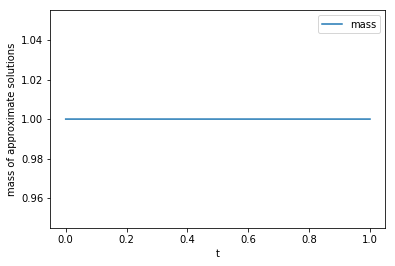

In [208]:
plot_t_curves(array1=mass, label1="mass", name="mass of approximate solutions")

In [3]:
# estimations d'erreurs locales:
err_loc = numpy.zeros((Nt+1,Nx))
err_loc_norm = numpy.zeros((Nt+1))

for nt in range(0,Nt):
    for i in range(0,Nx):                    
        ip = numpy.mod(i+1,Nx)
        im = numpy.mod(i-1,Nx)
        err_loc[nt,i] = 0        # todo

    # norme (L2) des erreurs locales, pour l'instant t = nt * dt
    tmp_sum = 0
    for i in range(0,Nx):
        tmp_sum += err_loc[nt,i]**2
    err_loc_norm[nt] = numpy.sqrt(h*tmp_sum)
        
    # err_loc_norm[nt+1] = numpy.sqrt((h**2)*numpy.sum(u_tx[nt+1,:]**2))


NameError: name 'numpy' is not defined

### stockage de quelques erreurs pour comparaison

In [162]:
err_loc_norm_1 = err_loc_norm
label_1 = repr(Nt)+"_"+repr(Nx)

In [175]:
err_loc_norm_2 = err_loc_norm
label_2 = repr(Nt)+"_"+repr(Nx)

In [210]:
err_loc_norm_3 = err_loc_norm
label_3 = repr(Nt)+"_"+repr(Nx)

In [4]:
plot_t_curves(
    array1=err_loc_norm_1, label1=label_1, 
    array2=err_loc_norm_2, label2=label_2, 
    array3=err_loc_norm_3, label3=label_3, 
    name="local error norms", logscale=True)

NameError: name 'err_loc_norm_1' is not defined

### animation de la dernière solution calculée

In [71]:
# animation function
def animate(nt):
    line.set_data(X, u_tx[nt,:])
    #line2.set_data(X, u_ex(nt*dt,X))
    return (line,line2)
#plt.show()    

In [5]:
# call the animator. 
# interval: Delay between frames in milliseconds. Defaults to 200.
# blit=True means only re-draw the parts that have changed.
# see https://matplotlib.org/api/_as_gen/matplotlib.animation.FuncAnimation.html

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=Nt+1, interval=20, blit=True)
HTML(anim.to_html5_video())

NameError: name 'animation' is not defined